# 4. Merging individual timepoints of a 3D timelapse for further plotting

In this notebook, we demonstrate how to load individual timepoints of a multichannel image as a stack into napari, extract features and plot using the `napari-clusters-plotter`.

In [1]:
import napari
from napari.utils import nbscreenshot
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np
import os
from skimage.io import imread
import numpy as np
from skimage import measure
from napari_clusters_plotter._dimensionality_reduction import DimensionalityReductionWidget
from napari_clusters_plotter._dock_widget import PlotterWidget
from napari_skimage_regionprops import add_table

## Merging timepoints and opening nuclei-, membrane- and label-channel in napari

We use a timelapse dataset of the marine annelid Platynereis dumerilii from  [Ozpolat, B. et al](https://doi.org/10.5281/zenodo.1063531) licensed by [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/legalcode) (rescaled to 256x256x103). We use the nuclei-channel, the membrane-channel and [StarDist](https://github.com/stardist/stardist)-labels. Currently have the individual timepoints as tif-files in separate folders. So we merge these timepoints first by opening them as a stack in napari.

In [2]:
nuclei_loc = "C:/Users/maral/Documents/WHK Bio-image Analysis Group/1. Nuclei und Zellen segmentieren, tracken, klassifizieren/Image 6 single timepoints gaussian (256x256x103)/"
membrane_loc = "C:/Users/maral/Documents/WHK Bio-image Analysis Group/1. Nuclei und Zellen segmentieren, tracken, klassifizieren/Image 6 single timepoints gaussian channel 0(256x256x103)/"
label_loc = "C:/Users/maral/Documents/WHK Bio-image Analysis Group/1. Nuclei und Zellen segmentieren, tracken, klassifizieren/Image 6 single timepoints labels/"

In [3]:
#append directory and sort
def get_sorted_image_list(directory):
    files = [join(directory, f) for f in listdir(directory) if isfile(join(directory, f)) and f.endswith('tif')]
    return sorted(files)

In [4]:
all_nuclei_locs = get_sorted_image_list(nuclei_loc)
all_membrane_locs = get_sorted_image_list(membrane_loc)
all_label_locs = get_sorted_image_list(label_loc)

In [5]:
#open napari 
viewer = napari.Viewer()
viewer.open(all_nuclei_locs, stack=True, plugin="builtins")
viewer.open(all_membrane_locs, stack=True, plugin="builtins")
viewer.layers[0].name = "nuclei"
viewer.layers[1].name = "membranes"

In [6]:
viewer.dims.ndisplay=3

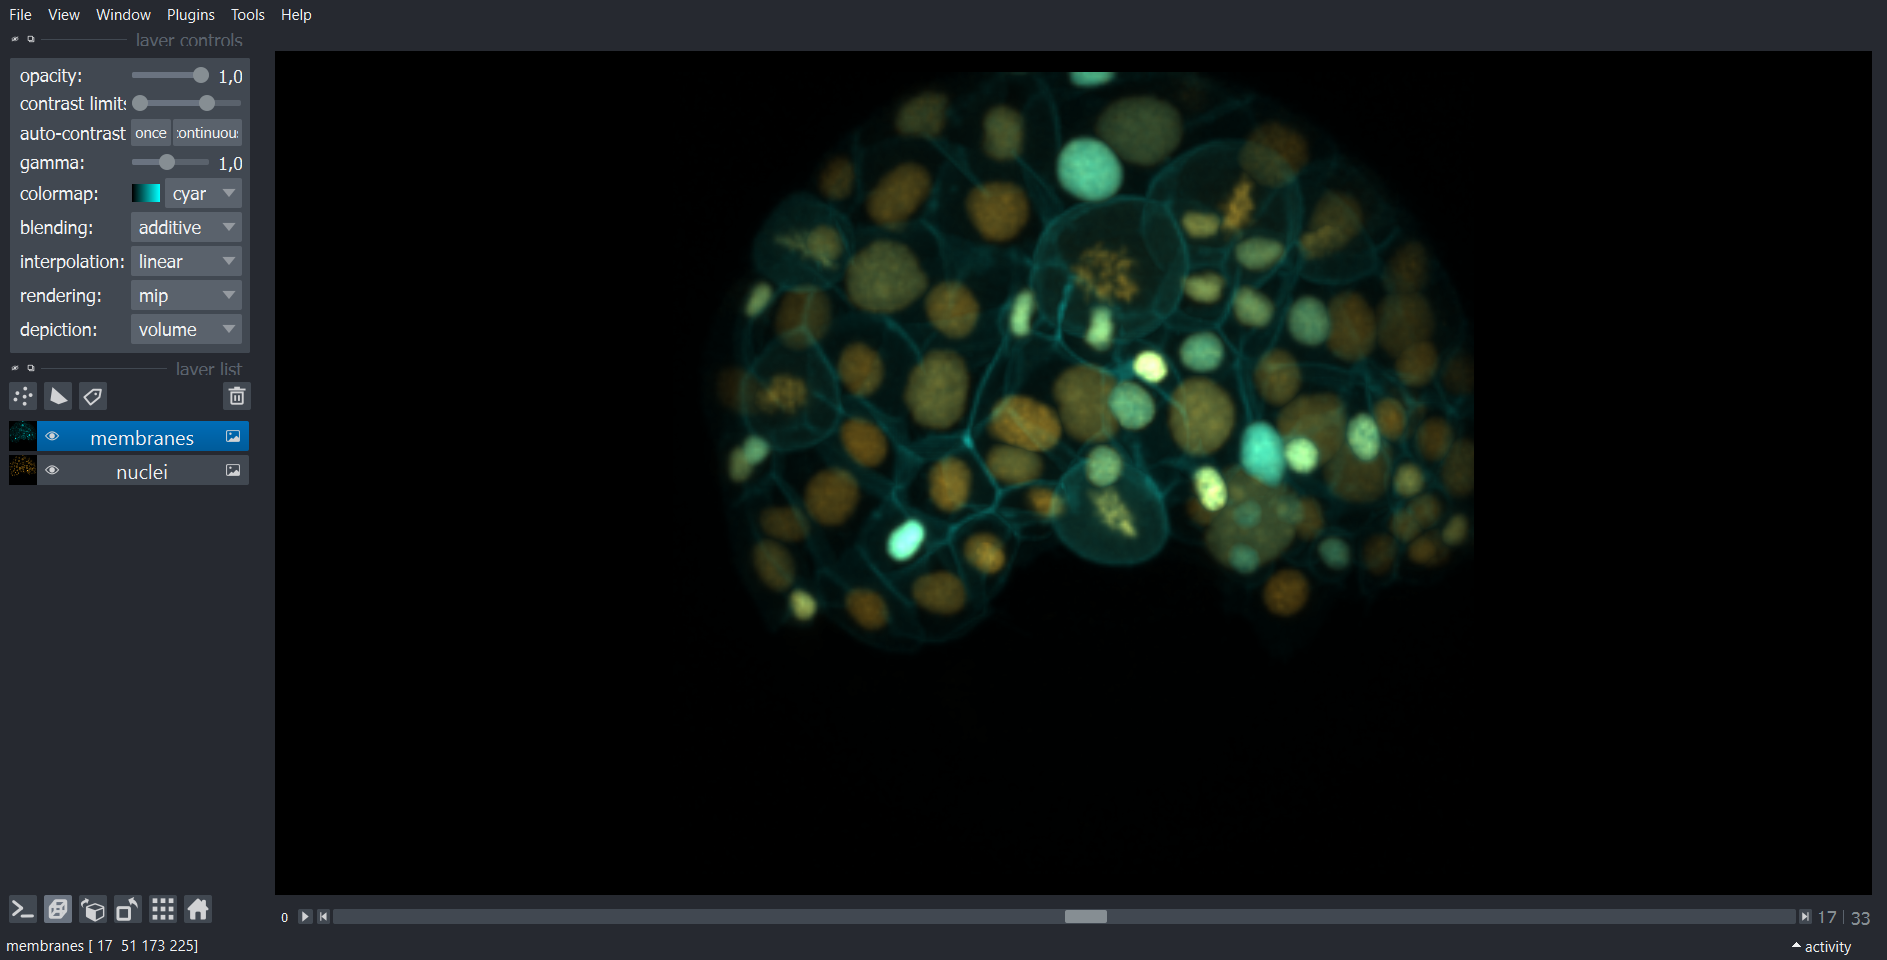

In [7]:
nbscreenshot(viewer)

In [7]:
#convert folders to 2D timelaps --> behaves like a stack
nuclei_layer = viewer.layers["nuclei"]
membrane_layer = viewer.layers["membranes"]

## Feature Extraction

This dataset has a nuclei channel (right) and a membrane channel which also contains part of the nuclei (left). We are now analysing the nucle-channel further.

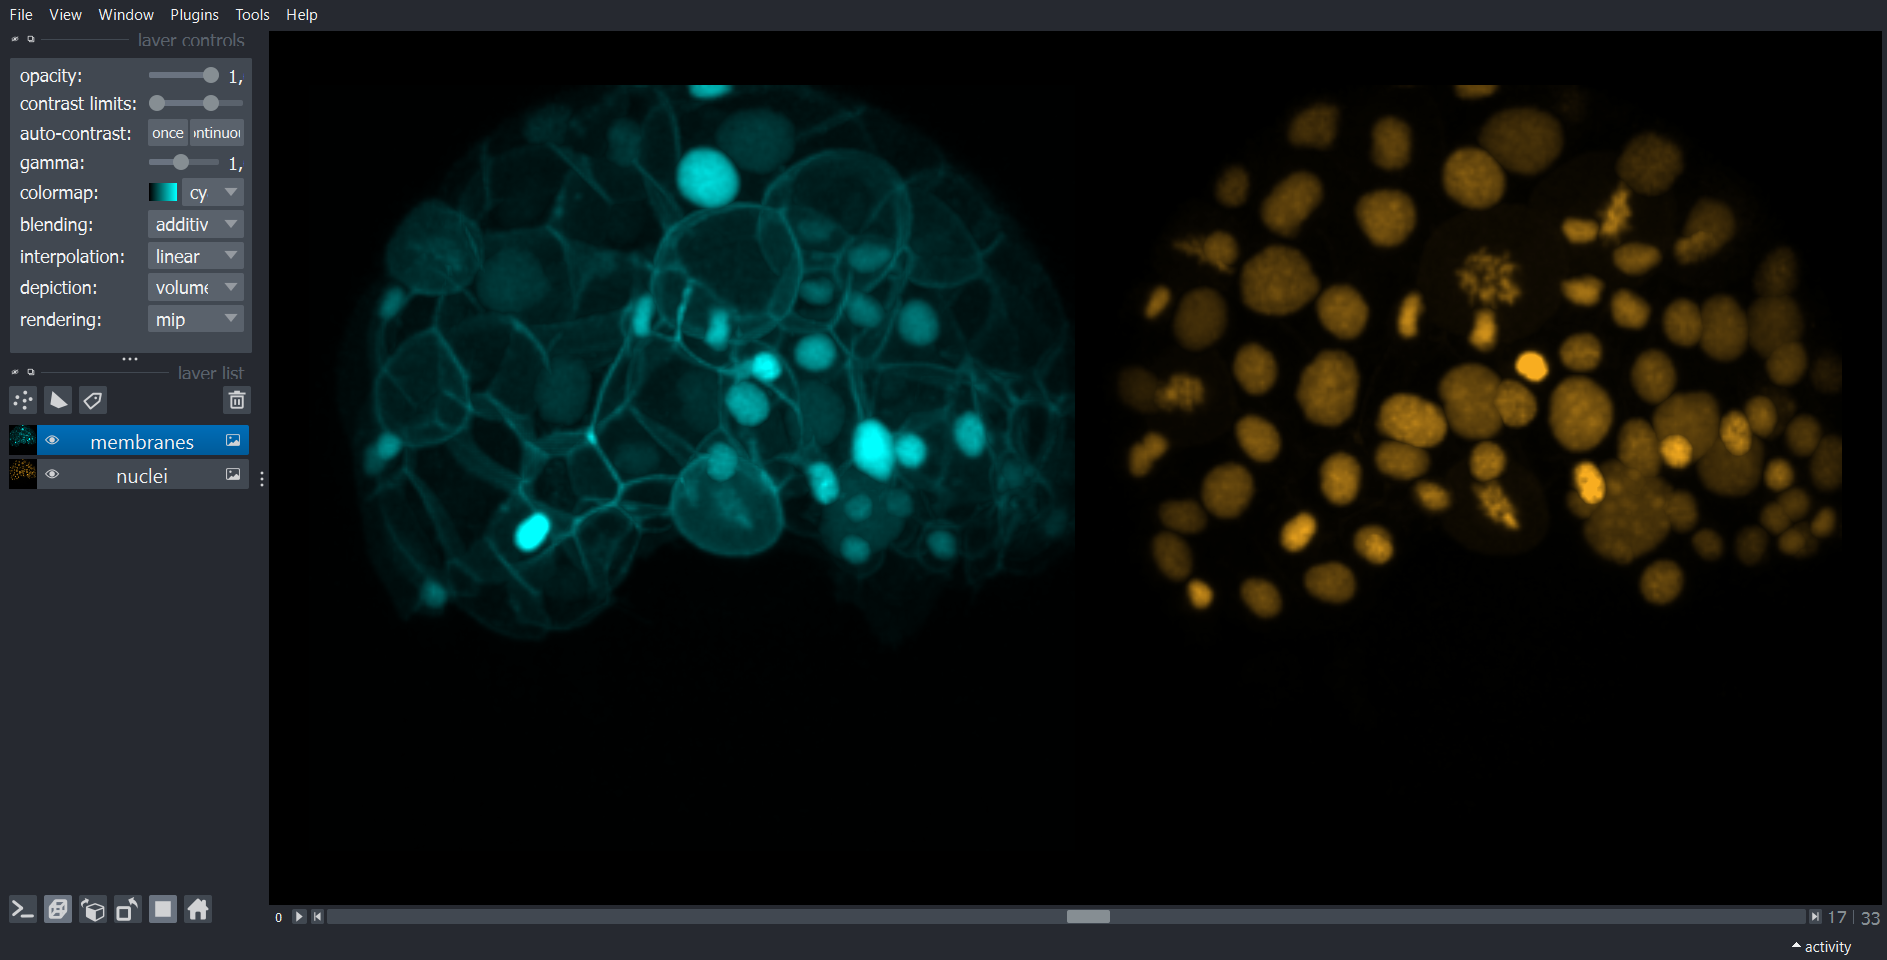

In [15]:
nbscreenshot(viewer)

## ...from the nuclei channel

Add frame column to indicate that it is a timelapse and select all measurements we are interested in using `skimage.measure`

In [8]:
nuclei_list = []
for labels, nuclei, i in zip(all_label_locs, all_nuclei_locs, range(len(all_nuclei_locs))):
    labels = imread(labels)
    nuclei = imread(nuclei)
    table = pd.DataFrame(measure.regionprops_table(labels, nuclei, properties=['label', 
                                                                                'area', 
                                                                                'axis_major_length', 
                                                                                'axis_major_length', 
                                                                                'feret_diameter_max', 
                                                                                'solidity', 
                                                                                'intensity_mean',
                                                                                'intensity_max',
                                                                                'intensity_min'
    ]))
    table['frame'] = i
    nuclei_list.append(table)

Now we connect the measurements of the individual timepoints. The resulting table looks like this:

In [9]:
nuclei_table = pd.concat(nuclei_list)
nuclei_table

label   area  axis_major_length  feret_diameter_max  solidity  \
0        1  39213          60.885716           59.270566  0.946579   
1        2  24982          53.531667           52.545219  0.944035   
2        3  21173          45.840576           45.880279  0.932690   
3        4  17760          39.187404           39.761791  0.931501   
4        5  18332          47.594375           45.000000  0.942180   
..     ...    ...                ...                 ...       ...   
192    193   1516          15.846743           17.233688  0.912154   
193    194    663          18.755101           20.420578  0.815498   
194    195   1638          21.803616           21.794495  0.900495   
195    196   1737          24.254017           24.372115  0.802680   
196    197   1678          26.363325           26.324893  0.875783   

     intensity_mean  intensity_max  intensity_min  frame  
0          0.136680       0.297344       0.011053      0  
1          0.102371       0.247868       0.008247      0  
2          0.107302       0.363302       0.012222      0  
3          0.073819       0.196801       0.008310      0  
4          0.084881       0.165792       0.006476      0  
..              ...            ...            ...    ...  
192        0.052266       0.074895       0.017502     33  
193        0.351559       0.744285       0.067796     33  
194        0.199831       0.430042       0.053522     33  
195        0.248964       0.463827       0.059397     33  
196        0.206445       0.408523       0.042788     33  

[3048 rows x 9 columns]

Next we connect the `nuclei_table` to our label layer:

In [10]:
viewer.open(all_label_locs, stack=True, plugin="builtins", layer_type = "labels", features = nuclei_table)
viewer.layers[2].name = "nuclei labels"
label_layer = viewer.layers["nuclei labels"]
add_table(label_layer, viewer)

Napari status bar display of label properties disabled because https://github.com/napari/napari/issues/5417 and https://github.com/napari/napari/issues/4342


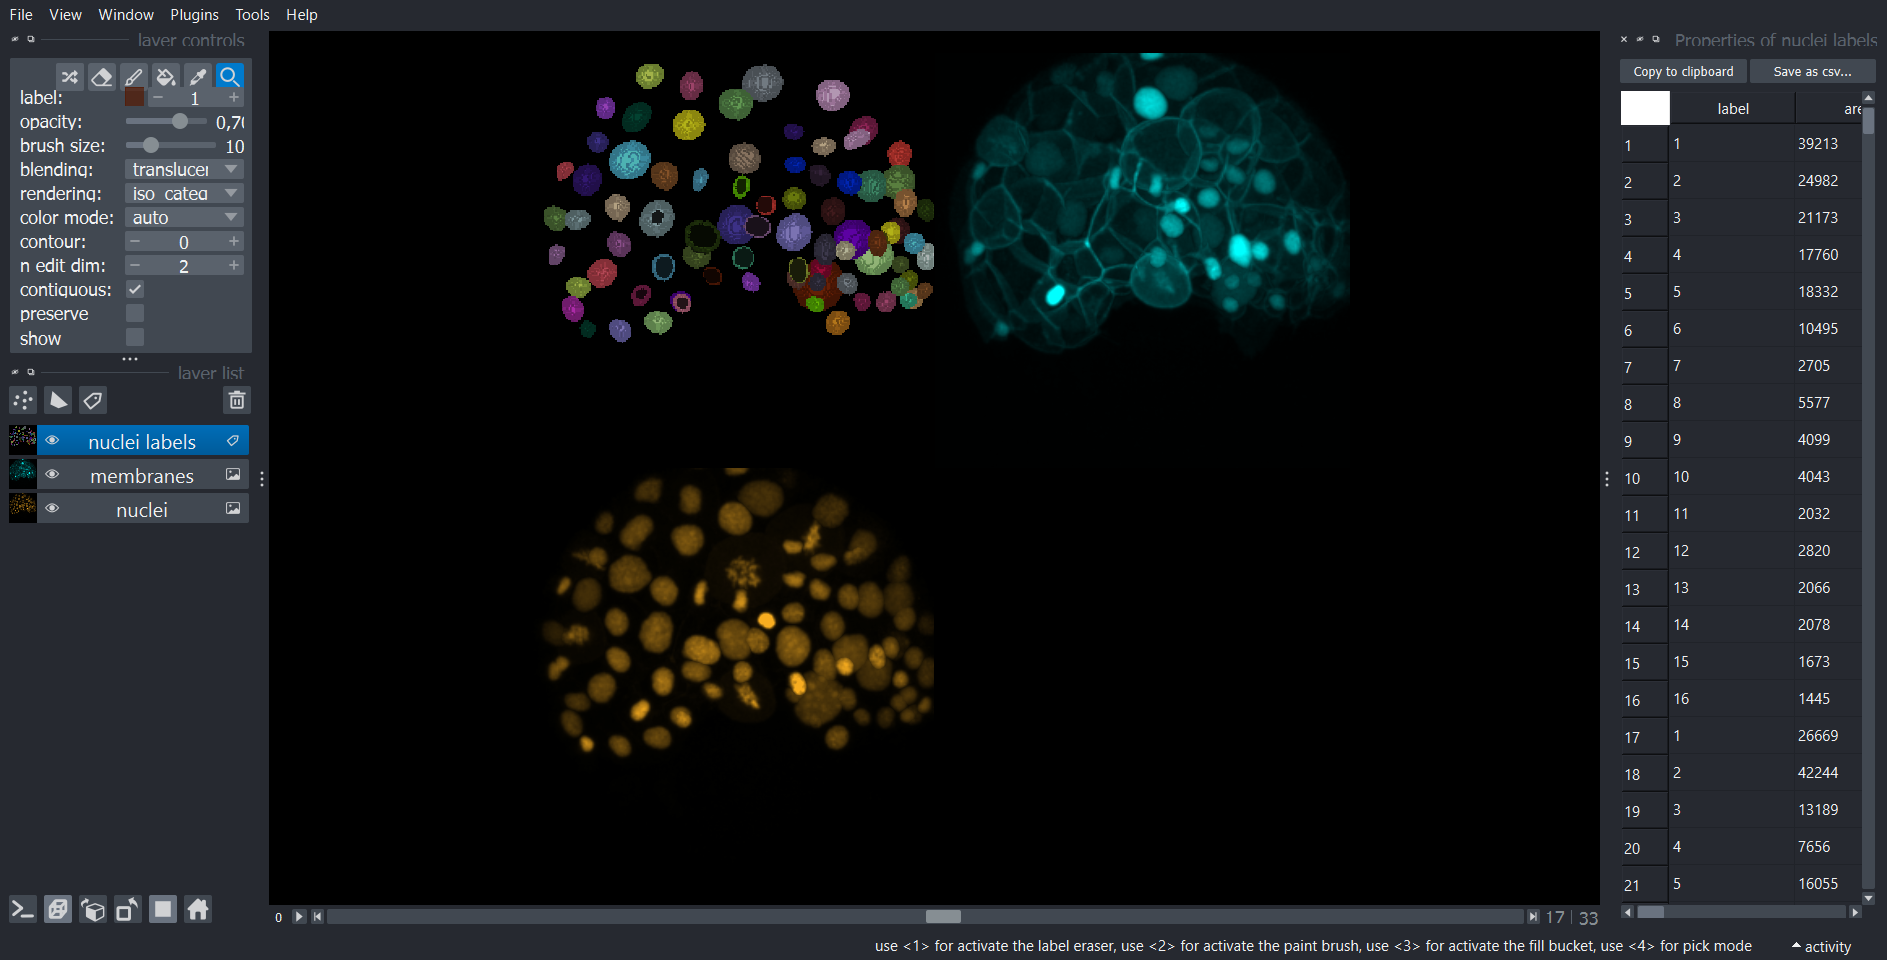

In [17]:
nbscreenshot(viewer)

## Dimensionality reduction

In [12]:
dimensionality_reduction_widget = DimensionalityReductionWidget(viewer)
dimensionality_reduction_dock_widget = viewer.window.add_dock_widget(dimensionality_reduction_widget)

Now we select the `nuclei layer` as the measurements are linked to this layer. We also select `UMAP` as a dimensionality reduction method and  click the `Run` button

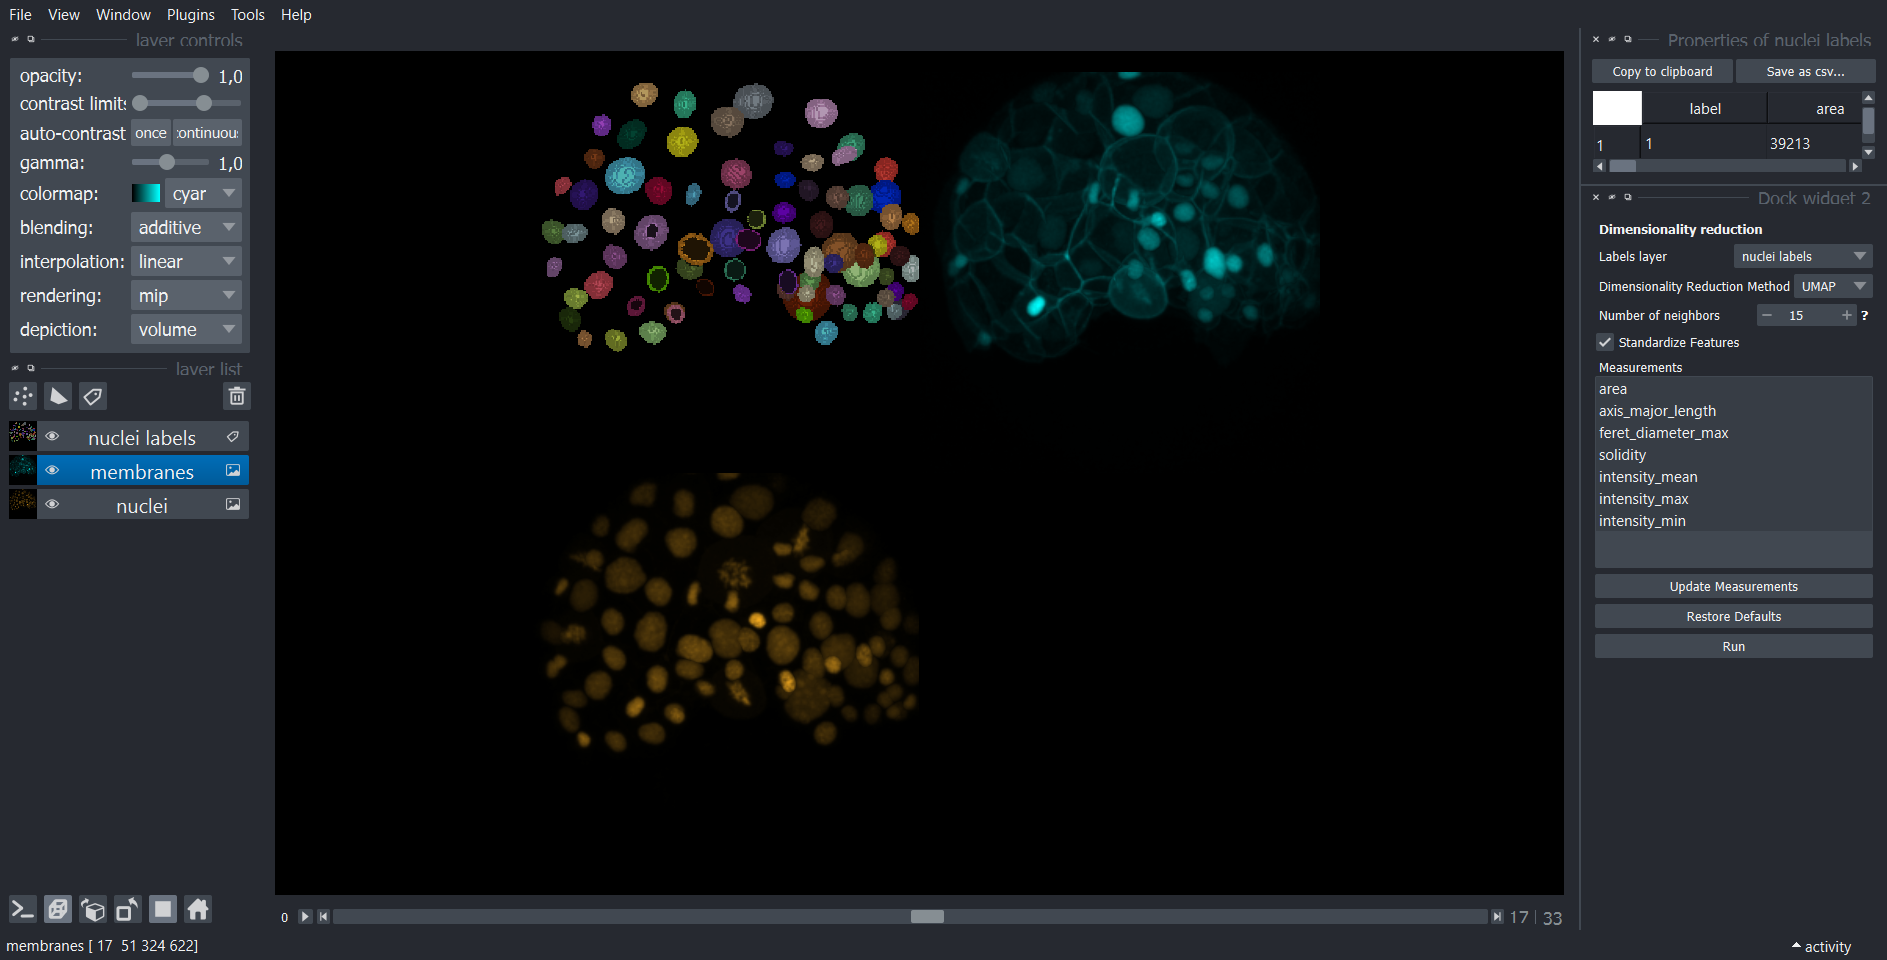

Selected labels layer: nuclei labels
Selected measurements: ['area', 'axis_major_length', 'feret_diameter_max', 'solidity', 'intensity_mean', 'intensity_max', 'intensity_min']
UMAP(random_state=133, verbose=True)
Wed Mar 29 17:01:25 2023 Construct fuzzy simplicial set
Wed Mar 29 17:01:29 2023 Finding Nearest Neighbors
Wed Mar 29 17:01:29 2023 Finished Nearest Neighbor Search
Wed Mar 29 17:01:29 2023 Construct embedding


Dimensionality reduction progress:   0%|            0/500 [00:00]

Wed Mar 29 17:01:34 2023 Finished embedding
Napari status bar display of label properties disabled because https://github.com/napari/napari/issues/5417 and https://github.com/napari/napari/issues/4342
Dimensionality reduction finished


In [14]:
nbscreenshot(viewer)

In [17]:
dimensionality_reduction_widget.hide()

Our UMAP columns were automatically added to the table:

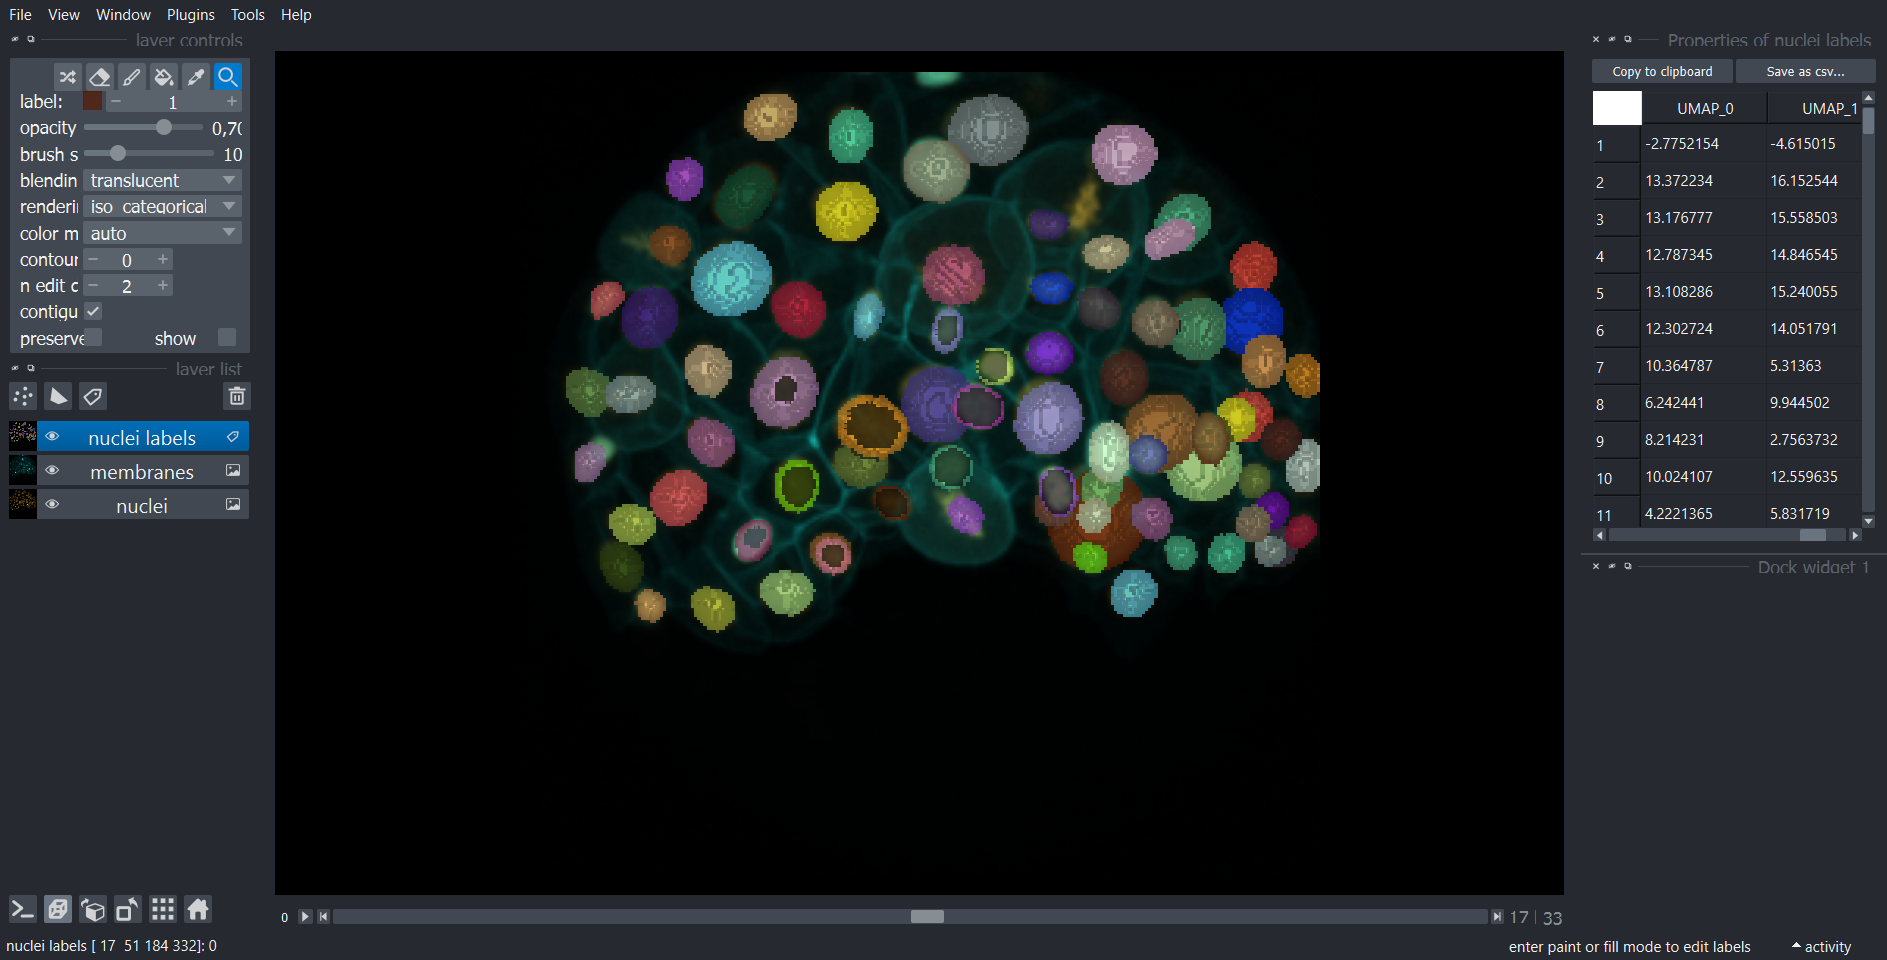

In [18]:
nbscreenshot(viewer)

## Plotting

In [19]:
plotter_widget = PlotterWidget(viewer)
plotter_dock_widget = viewer.window.add_dock_widget(plotter_widget)

In [21]:
plotter_widget.plot_x_axis.setCurrentText("UMAP_0")
plotter_widget.plot_y_axis.setCurrentText("UMAP_1")

# workaround to click run button programmatically
layout = plotter_widget.layout()
widgetitem = layout.itemAt(layout.count()-2)
run_button = widgetitem.widget().layout().itemAt(0).widget()
run_button.clicked.emit()

The workaround with `Run` button taken from [this notebook](https://github.com/BiAPoL/napari-clusters-plotter-example-notebooks/blob/main/notebooks/plotting_in_napari.ipynb)

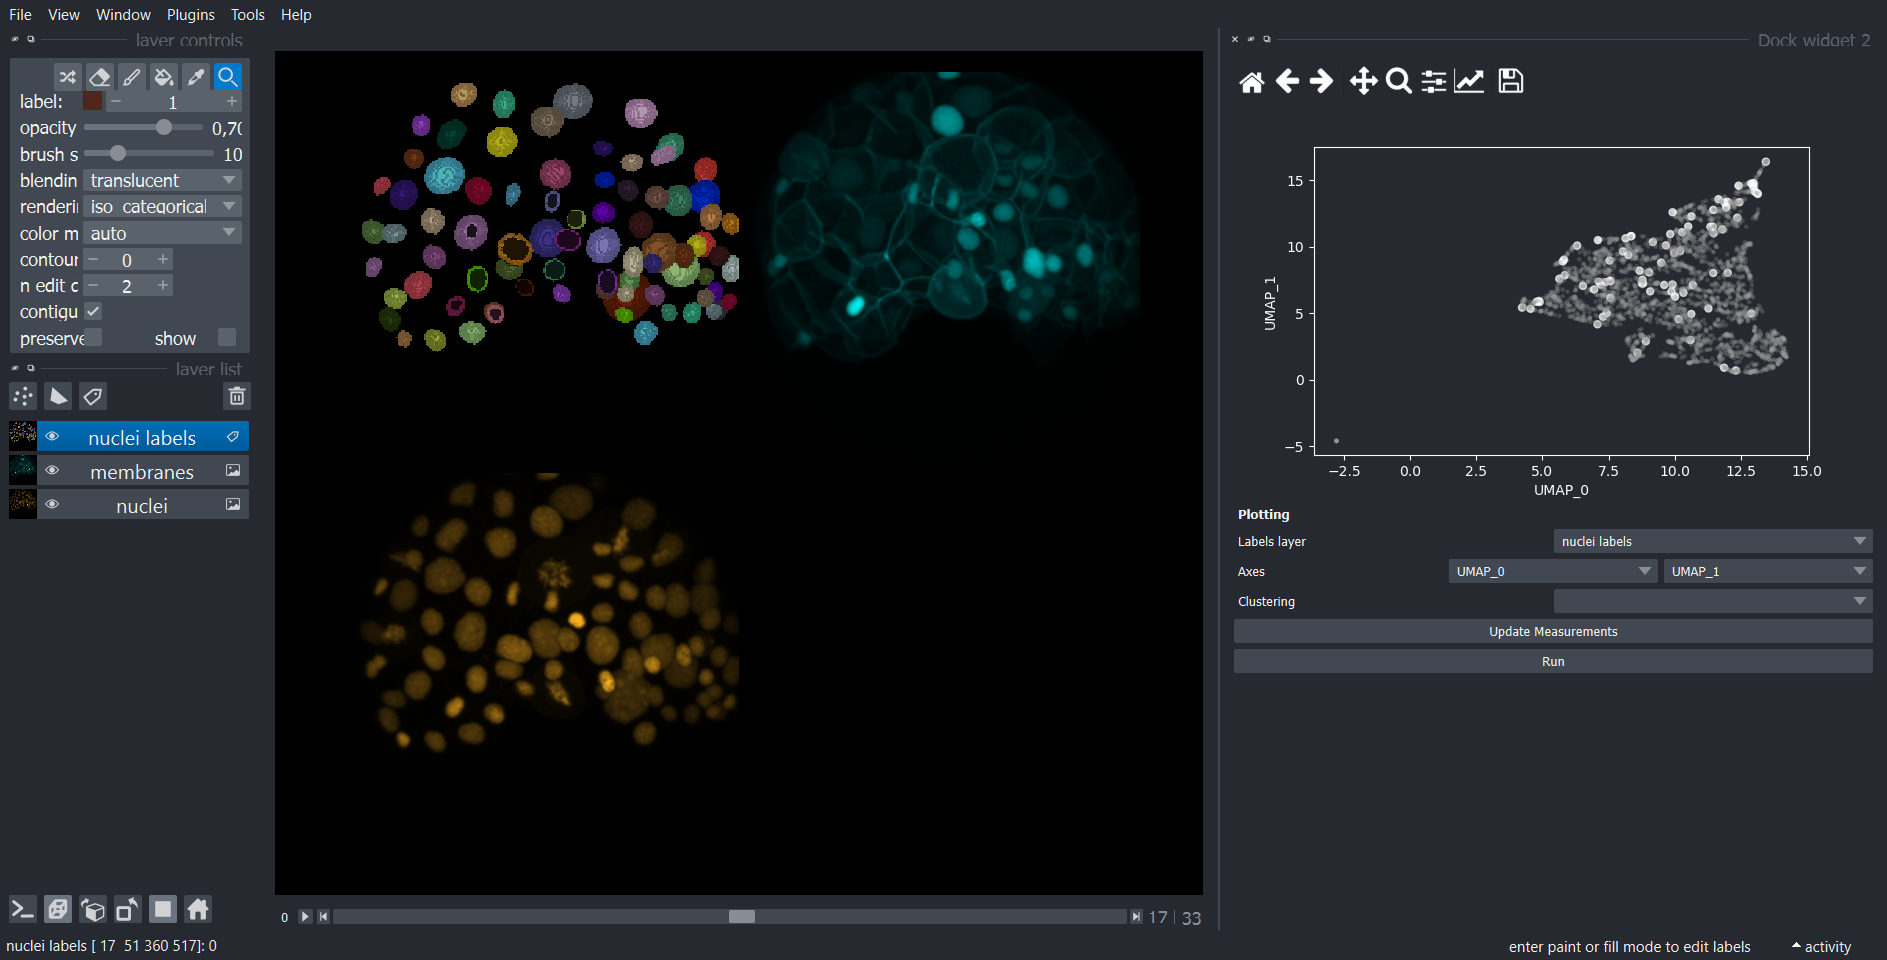

In [24]:
nbscreenshot(viewer)

Now we are manually clustering using the `lasso tool`

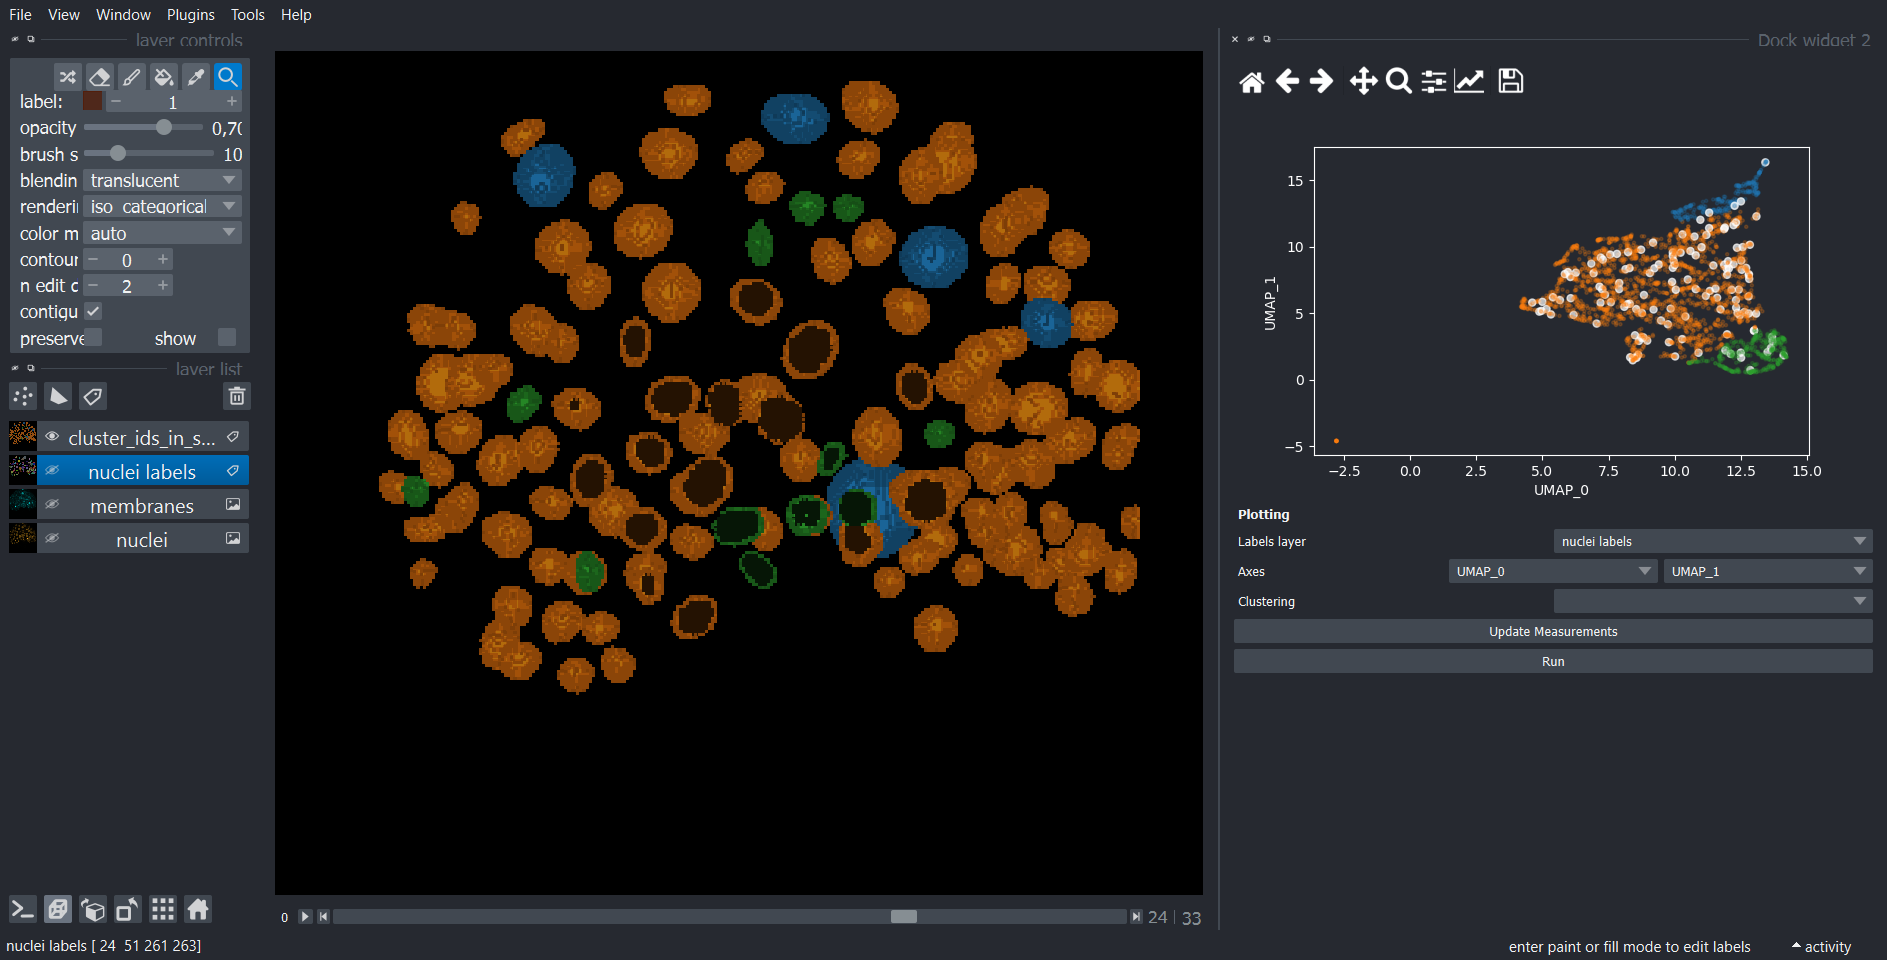

In [26]:
nbscreenshot(viewer)

Maybe the size of the objects played a role to form these clusters. We are investigating this by keeping our `MANUAL_CLUSTER_ID` and plotting `area` against `axis_major_length`

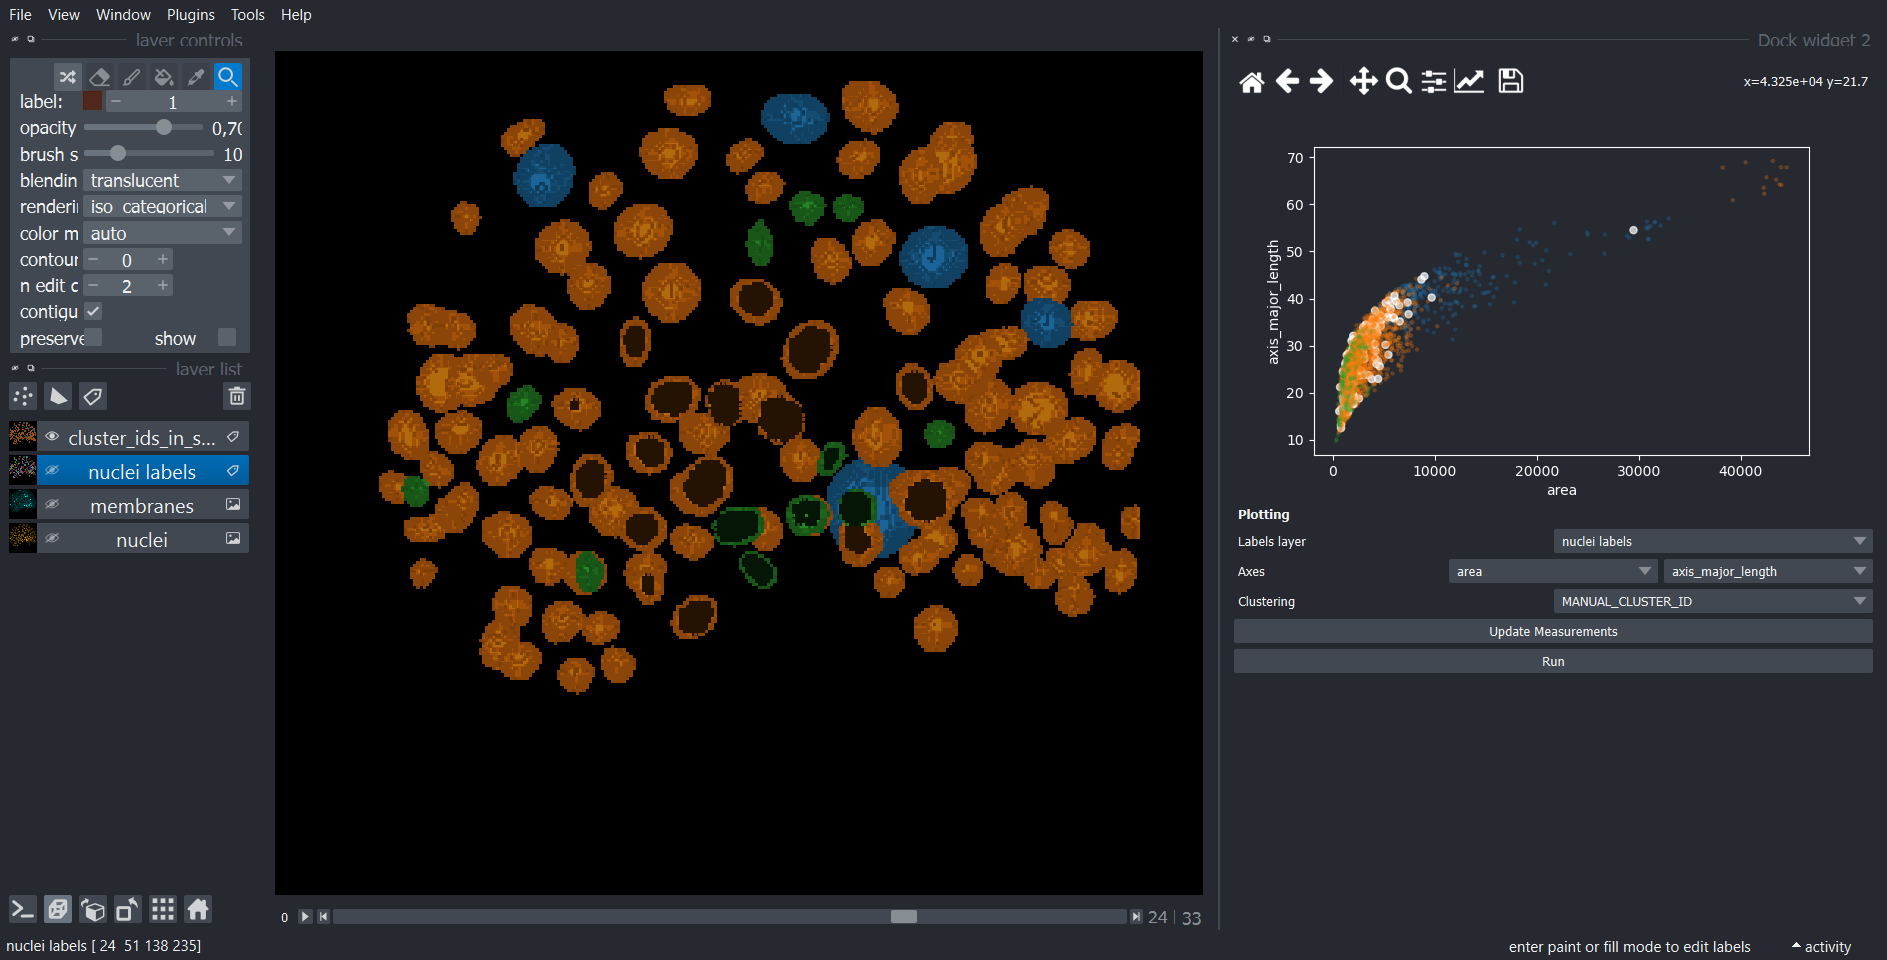

In [28]:
nbscreenshot(viewer)

The clustered objects in green tend to be smaller and the blue ones larger.

 We are also investigating intensity by keeping our `MANUAL_CLUSTER_ID` and plotting `area` against `intensity mean`

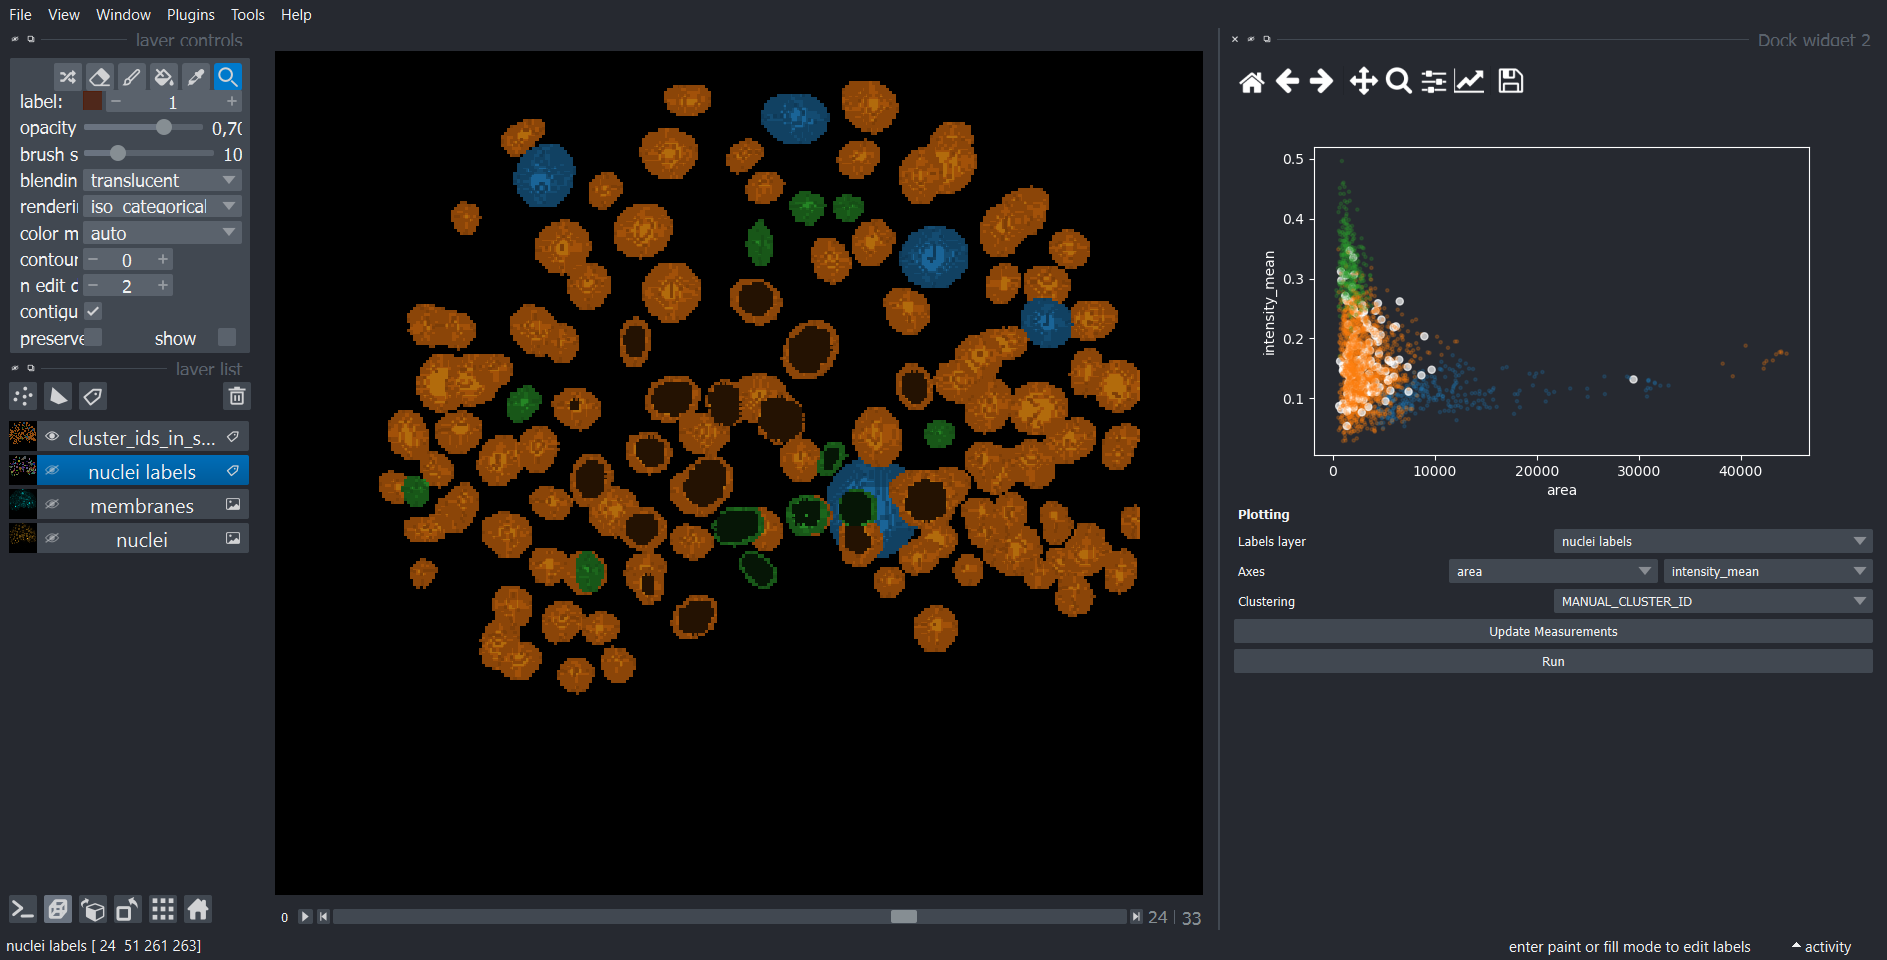

In [27]:
nbscreenshot(viewer)

The clustered objects in green seem to have a higher mean intensity than the larger objects.